In [7]:
!pip install -q wordcloud
!pip install matplotlib
!pip install vaderSentiment
!pip install NRCLex
!pip install seaborn
!pip install tensorflow == 2.10.0
!pip install keras
!pip install scikit-learn
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip install nltk
!pip install pandas

nltk.download('stopwords')

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
  Using cached NRCLex-4.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached textblob-0.18.0.post0-py3-none-any.whl.metadata (4.5 kB)
INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
  Using cached NRCLex-3.0.0-py3-none-any.whl
Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.10.0


  Using cached pydotplus-2.0.2-py3-none-any.whl
   ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.0 kB 330.3 kB/s eta 0:00:01
   ---------------------------------------- 47.0/47.0 kB 395.7 kB/s eta 0:00:00


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jneig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import the Dataset

In [8]:
from nrclex import NRCLex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import DataFrame as df
import matplotlib.pyplot as mp
import numpy as np

In [2]:
import nltk

In [10]:
stop = stopwords.words('english')

df = pd.read_csv("./datasets/train2Data.csv", encoding="utf-8", sep=',')
df = df.sample(frac=1).reset_index(drop=True)

df.rename(columns={'Tweets': 'text', ' Label': 'label'}, inplace=True)

df['Message Size'] = df['text'].apply(lambda x: len(x))

#Remove stopwords from the dataset
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in ['amp', 'quot']]))

analyzer = SentimentIntensityAnalyzer()

print("Getting Fear")
df['fear'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('fear', 0))

print("Getting Anger")
df['anger'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('anger', 0))

print("Getting Anticipation")
df['anticipation'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('anticipation', 0))

print("Getting Trust")
df['trust'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('trust', 0))

print("Getting Surprise")
df['surprise'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('surprise', 0))

print("Getting Positive")
df['positive'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('positive', 0))

print("Getting Negative")
df['negative'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('negative', 0))

print("Getting Sadness")
df['sadness'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('sadness', 0))

print("Getting Disgust")
df['disgust'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('disgust', 0))

print("Getting Joy")
df['joy'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('joy', 0))

for index, row in df.iterrows():
    sentence = row['text']
    sentiment = analyzer.polarity_scores(sentence)

    df.at[index, 'negative'] = sentiment['neg']
    df.at[index, 'neutral'] = sentiment['neu']
    df.at[index, 'positive'] = sentiment['pos']
    #df.at[index, 'compound'] = sentiment['compound']

Getting Fear
Getting Anger
Getting Anticipation
Getting Trust
Getting Surprise
Getting Positive
Getting Negative
Getting Sadness
Getting Disgust
Getting Joy


C:\Users\jneig\AppData\Local\Temp\ipykernel_34220\1806680412.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.149' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'negative'] = sentiment['neg']
C:\Users\jneig\AppData\Local\Temp\ipykernel_34220\1806680412.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.276' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'positive'] = sentiment['pos']


In [ ]:
df1 = df.copy();

df1.drop(columns=['text'], inplace=True)

plt.figure(figsize=(15, 15))
# plotting correlation heatmap 
dataplot = sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap 
mp.show()

In [11]:
##Split dataframe into testing and validation to ensure no leakage
testing_dataframe = df.iloc[:10000]
training_dataframe = df.iloc[10000:]

testing_dataframe


,text,label,Message Size,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy,neutral
0,okay wait test subjects started whole thing be...,0,164,1,1,1,0,0,0.276,0.149,0,0,0,0.575
1,talking end dig dug talk like askwallows,0,75,0,0,0,0,0,0.294,0.000,0,0,0,0.706
2,found jesys documentary depression damn shes s...,1,79,0,1,0,1,0,0.241,0.467,1,1,1,0.292
3,yes supporting evidence article spells data sh...,0,153,0,0,0,1,0,0.579,0.000,0,0,0,0.421
4,like see die hard man fans ever manchester yet...,1,212,2,2,1,0,0,0.071,0.389,2,1,0,0.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,time doesnt make lose friends helps identify t...,0,77,1,1,1,1,1,0.503,0.168,1,1,1,0.329
9996,mental health actually sucks one minute amazin...,1,144,2,2,1,1,0,0.242,0.389,2,1,1,0.369
9997,woke feeling genuinely happy today although le...,1,223,1,2,2,2,1,0.195,0.243,2,2,2,0.562
9998,want drink together three days show salute giv...,0,160,1,1,1,3,1,0.428,0.119,2,1,3,0.453


In [12]:
def tokenize(dataframe):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, split=' ')
    tokenizer.fit_on_texts(dataframe['text'].values)
    X_text = tokenizer.texts_to_sequences(dataframe['text'].values)
    X_text = tf.keras.utils.pad_sequences(X_text, 300)
    return X_text


def get_attr_from_dataframe(dataframe):
    X_attr = dataframe.loc[:, dataframe.columns != 'text']
    X_attr = X_attr.drop('label', axis=1)
    return X_attr


X_text_training_dataframe = tokenize(training_dataframe)
X_attr_training_dataframe = get_attr_from_dataframe(training_dataframe)
Y_training_dataframe = training_dataframe['label']

X_text_testing_dataframe = tokenize(testing_dataframe)
X_attr_testing_dataframe = get_attr_from_dataframe(testing_dataframe)
Y_testing_dataframe = testing_dataframe['label']



# Basic Sequential Model

In [262]:
embedding_dim = 64

x = Sequential()

x.add(Input(shape=(X_text.shape[1],)))
x.add(Embedding(max_fatures, embedding_dim, input_length=X_text.shape[1]))
x.add(Dense(128, activation='relu'))
x.add(BatchNormalization())
x.add(Dropout(0.5))
x.add(Dense(8, activation="relu"))
x.add(Dropout(0.2))
x.add(Dense(1, activation="sigmoid"))

x.compile(optimizer="adam", loss='binary_crossentropy', metrics='accuracy')

H = x.fit(x=X_train, y=Y_train, validation_data=(X_test, Y_test), epochs=30,
          verbose=1, batch_size=16)


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 36, 128)           256000    
                                                                 
 dense_75 (Dense)            (None, 36, 16)            2064      
                                                                 
 dense_76 (Dense)            (None, 36, 1)             17        
                                                                 
Total params: 258081 (1008.13 KB)
Trainable params: 258081 (1008.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/7
635/775 [=======================>......] - ETA: 0s - loss: 0.6432 - accuracy: 0.5910

KeyboardInterrupt: 

# Hybrid Model Accepting Attribute Data

In [22]:
embedding_dim = 64

input1 = tf.keras.layers.Input(shape=(X_text_training_dataframe.shape[1],))

embedding_layer = tf.keras.layers.Embedding(1000, embedding_dim, input_length=30)(input1)

x = tf.keras.layers.Flatten()(embedding_layer)

x = tf.keras.Model(inputs=input1, outputs=x)

input2 = tf.keras.layers.Input(shape=(X_attr_training_dataframe.shape[1]))

merge = tf.keras.layers.concatenate([x.output, input2])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

output = tf.keras.layers.Dense(12, activation='relu')(merge)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(8, activation='relu')(output)
output = tf.keras.layers.Dropout(0)(output)

output = tf.keras.layers.Dense(1, activation="sigmoid")(output)

model = tf.keras.Model(inputs=[x.input, input2], outputs=output)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='binary_accuracy')

H = model.fit(x=[X_text_training_dataframe, X_attr_training_dataframe], y=Y_training_dataframe,
              validation_data=([X_text_testing_dataframe, X_attr_testing_dataframe], Y_testing_dataframe), epochs=100,
              verbose=1, batch_size=128)

Epoch 1/100
165/165 [==============================] - 4s 15ms/step - loss: 0.6881 - binary_accuracy: 0.5166 - val_loss: 0.6677 - val_binary_accuracy: 0.6968
Epoch 2/100
165/165 [==============================] - 2s 12ms/step - loss: 0.5981 - binary_accuracy: 0.7163 - val_loss: 0.6173 - val_binary_accuracy: 0.8024
Epoch 3/100
165/165 [==============================] - 2s 12ms/step - loss: 0.5595 - binary_accuracy: 0.8221 - val_loss: 0.5578 - val_binary_accuracy: 0.7736
Epoch 4/100
165/165 [==============================] - 2s 12ms/step - loss: 0.5227 - binary_accuracy: 0.8512 - val_loss: 0.5124 - val_binary_accuracy: 0.7223
Epoch 5/100
142/165 [========================>.....] - ETA: 0s - loss: 0.4899 - binary_accuracy: 0.8592

KeyboardInterrupt: 

In [55]:
import tensorflow
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Flatten, concatenate, Dense, Input, Embedding, Dropout


import optuna


def objective(trial):
    embedding_dim = 64
    learning_rate = trial.suggest_float('learning_rate', 0.00001, 0.01)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.8)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.8)
    dense_units_1 = trial.suggest_int('dense_units_1', 4, 512)
    dense_activation_function_1 = trial.suggest_categorical('dense_activation_function_1', ['relu', 'selu', 'elu', 'leaky_relu', 'relu6', 'silu','gelu'])
    dense_activation_function_2 = trial.suggest_categorical('dense_activation_function_2', ['relu', 'selu', 'elu', 'leaky_relu', 'relu6', 'silu','gelu'])
    dense_units_2 = trial.suggest_int('dense_units_2', 4, 512)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])

    normalisation_1 = trial.suggest_categorical('normalisation_1', [True, False])
    normalisation_2 = trial.suggest_categorical('normalisation_2', [True, False])
        
    # Build the model using hyperparameters
    input1 = Input(shape=(X_text_training_dataframe.shape[1],))
    embedding_layer = Embedding(1000, embedding_dim, input_length=30)(input1)
    x = Flatten()(embedding_layer)
    x = Model(inputs=input1, outputs=x)

    input2 = Input(shape=(X_attr_training_dataframe.shape[1]))
    merge = concatenate([x.output, input2])
    
    output = Dense(dense_units_1, activation=dense_activation_function_1)(merge)

    output = Dropout(dropout_rate_1)(output)

    if normalisation_1 == True:
        output = tensorflow.keras.layers.BatchNormalization()(output)
    
    output = Dense(dense_units_2, activation=dense_activation_function_2)(output)
    
    output = Dropout(dropout_rate_2)(output)
    
    if normalisation_2 == True:
        output = tensorflow.keras.layers.BatchNormalization()(output)
    
    output = Dense(1, activation="sigmoid")(output)

    model = Model(inputs=[x.input, input2], outputs=output)

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
  

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    model.fit(x=[X_text_training_dataframe, X_attr_training_dataframe], y=Y_training_dataframe,
              validation_data=([X_text_testing_dataframe, X_attr_testing_dataframe], Y_testing_dataframe), epochs=150,
              batch_size=batch_size, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model on the validation set
    score = model.evaluate([X_text_testing_dataframe, X_attr_testing_dataframe], Y_testing_dataframe, verbose=0)
    
    # Return the validation accuracy as the optimization target
    return score[1]

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="Depression Detection Model With Dropout and Normalization V2", load_if_exists=True)
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and their corresponding accuracy
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-11 08:36:18,959] Using an existing study with name 'Depression Detection Model With Dropout and Normalization V2' instead of creating a new one.
[I 2024-03-11 08:37:00,382] Trial 316 finished with value: 0.9437000155448914 and parameters: {'learning_rate': 0.00017654349674161763, 'dropout_rate_1': 0.055532442961502025, 'dropout_rate_2': 0.030093888908658557, 'dense_units_1': 500, 'dense_activation_function_1': 'gelu', 'dense_activation_function_2': 'selu', 'dense_units_2': 395, 'batch_size': 16, 'normalisation_1': True, 'normalisation_2': False}. Best is trial 174 with value: 0.9627000093460083.
[I 2024-03-11 08:38:00,243] Trial 317 finished with value: 0.9455999732017517 and parameters: {'learning_rate': 0.0003569030172474977, 'dropout_rate_1': 0.015829539318769806, 'dropout_rate_2': 0.013119610512535844, 'dense_units_1': 512, 'dense_activation_function_1': 'silu', 'dense_activation_function_2': 'elu', 'dense_units_2': 384, 'batch_size': 16, 'normalisation_1': True, 'normal

KeyboardInterrupt: 

In [65]:
import tensorflow as tf

# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [69]:
import tensorflow

from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Flatten, concatenate, Dense, Input, Embedding, Dropout


import optuna


def objective(trial):
    
    embedding_dim = 64
    learning_rate = trial.suggest_float('learning_rate', 0.00001, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    number_of_layers = trial.suggest_int('layer_count', 2, 15)

    # Build the model using hyperparameters
    input1 = Input(shape=(X_text_training_dataframe.shape[1],))
    embedding_layer = Embedding(1000, embedding_dim, input_length=30)(input1)
    x = Flatten()(embedding_layer)
    x = Model(inputs=input1, outputs=x)
    input2 = Input(shape=(X_attr_training_dataframe.shape[1]))
    merge = concatenate([x.output, input2])

    for _ in range(number_of_layers):
        dense_units = trial.suggest_int("dense_units_{"+str(_)+"}", 4, 128)
        dense_activation_function = trial.suggest_categorical('dense_activation_function_{'+str(_)+'}', ['relu', 'selu', 'elu', 'leaky_relu', 'relu6', 'silu','gelu'])
        normalisation = trial.suggest_categorical('normalisation_{'+str(_)+'}', [True, False])
        dropout_rate = trial.suggest_float('dropout_rate_{'+str(_)+'}', 0.0, 0.8)

        
        if _ == 0:
            output = Dense(dense_units, activation=dense_activation_function)(merge)
        else:
            output = Dense(dense_units, activation=dense_activation_function)(output)

        output = Dropout(dropout_rate)(output)

        if normalisation == True:
            output = tensorflow.keras.layers.BatchNormalization()(output)

   

    output = Dense(1, activation="sigmoid")(output)

    model = Model(inputs=[x.input, input2], outputs=output)

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])


    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    model.fit(x=[X_text_training_dataframe, X_attr_training_dataframe], y=Y_training_dataframe,
              validation_data=([X_text_testing_dataframe, X_attr_testing_dataframe], Y_testing_dataframe), epochs=150,
              batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    # Evaluate the model on the validation set
    score = model.evaluate([X_text_testing_dataframe, X_attr_testing_dataframe], Y_testing_dataframe, verbose=0)

    # Return the validation accuracy as the optimization target
    return score[1]

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="Depression Detection Model With Dynamic Layer Scaling", load_if_exists=True)
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and their corresponding accuracy
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-11 15:40:31,313] Using an existing study with name 'Depression Detection Model With Dynamic Layer Scaling' instead of creating a new one.
[I 2024-03-11 15:40:57,723] Trial 120 finished with value: 0.9304999709129333 and parameters: {'learning_rate': 0.0001988307342341417, 'batch_size': 32, 'layer_count': 4, 'dense_units_{0}': 124, 'dense_activation_function_{0}': 'relu6', 'normalisation_{0}': True, 'dropout_rate_{0}': 0.16036818955292478, 'dense_units_{1}': 120, 'dense_activation_function_{1}': 'silu', 'normalisation_{1}': False, 'dropout_rate_{1}': 0.1958002666466966, 'dense_units_{2}': 107, 'dense_activation_function_{2}': 'relu6', 'normalisation_{2}': False, 'dropout_rate_{2}': 0.45381431075756967, 'dense_units_{3}': 121, 'dense_activation_function_{3}': 'leaky_relu', 'normalisation_{3}': True, 'dropout_rate_{3}': 0.20958213670486442}. Best is trial 55 with value: 0.9531000256538391.
[I 2024-03-11 15:41:17,863] Trial 121 finished with value: 0.9409999847412109 and paramet

KeyboardInterrupt: 

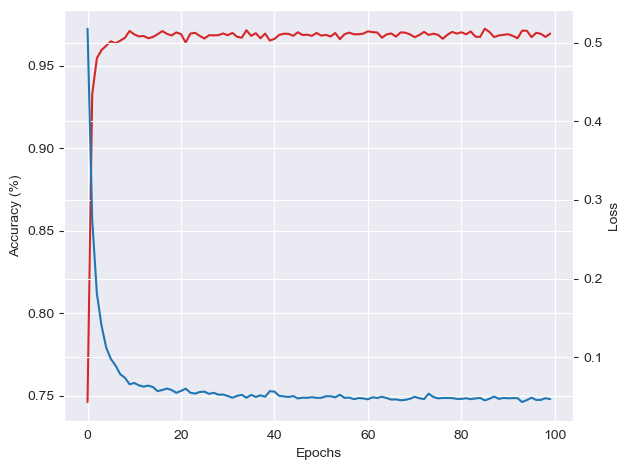

In [306]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(H.history['binary_accuracy'], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Loss')
ax2.plot(H.history['loss'], color=color)
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

In [309]:
from sklearn.metrics import confusion_matrix, roc_curve
from pandas import DataFrame

prediction = model.predict([X_text_testing_dataframe, X_attr_testing_dataframe])
DataFrame(prediction)

result = confusion_matrix(Y_testing_dataframe, np.round(prediction).tolist(), normalize='pred')

print(result)

485/485 [==============================] - 1s 3ms/step
[[0.94259567 0.08675193]
 [0.05740433 0.91324807]]


In [310]:
result = confusion_matrix(testing_dataframe['label'], np.round(prediction).tolist(), normalize='pred')

fpr_keras, tpr_keras, thresholds_keras = roc_curve(testing_dataframe['label'], prediction)
from sklearn.metrics import auc

auc_keras = auc(fpr_keras, tpr_keras)

<Axes: >

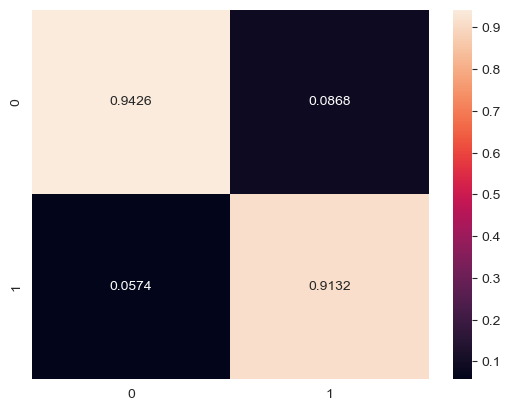

In [311]:
import seaborn as sns

sns.heatmap(result, annot=True, fmt=".4f")

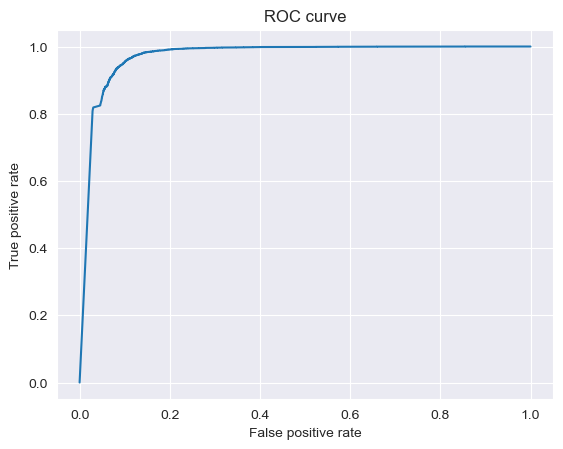

In [312]:
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()